In [1]:

# Install necessary packages
!apt-get -qq install -y cmake libopencv-dev

# Clone OpenCV repository
!git clone https://github.com/opencv/opencv.git
!git clone https://github.com/opencv/opencv_contrib.git

# Create build directory
!mkdir /content/build
%cd /content/build

# Configure OpenCV with CMake
!cmake -DOPENCV_ENABLE_NONFREE=ON -DOPENCV_EXTRA_MODULES_PATH=/content/opencv_contrib/modules /content/opencv

# Build and install OpenCV
!make -j8
!make install

Cloning into 'opencv'...
remote: Enumerating objects: 343826, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 343826 (delta 41), reused 23 (delta 23), pack-reused 343735 (from 2)
Receiving objects: 100% (343826/343826), 532.38 MiB | 22.75 MiB/s, done.
Resolving deltas: 100% (239899/239899), done.
Updating files: 100% (7620/7620), done.
Cloning into 'opencv_contrib'...
remote: Enumerating objects: 43422, done.
remote: Counting objects: 100% (6710/6710), done.
remote: Compressing objects: 100% (1769/1769), done.
remote: Total 43422 (delta 5405), reused 4941 (delta 4941), pack-reused 36712 (from 2)
Receiving objects: 100% (43422/43422), 152.17 MiB | 24.86 MiB/s, done.
Resolving deltas: 100% (26865/26865), done.
/content/build
CMake Deprecation Warning at CMakeLists.txt:25 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.

In [114]:
from pathlib import Path
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
import os
import random
from scipy.ndimage import gaussian_filter, convolve
from scipy.signal import convolve2d
from scipy.spatial import cKDTree
from skimage.feature import hog
import math
from numpy.fft import fft2, ifft2
import time

In [14]:
cd ..

/content


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
cd /content/drive/MyDrive/CV_Final

/content/drive/MyDrive/CV_Final


In [22]:
path = "/content/drive/My Drive/CV_Final/dataset/final_proj"

In [23]:
def load_dataset(root_dir):
    root = Path(root_dir)
    dataset = {}

    for folder in sorted(root.iterdir()):
        if not folder.is_dir():
            continue

        images = {}
        transforms = {}

        # 1) load all PPM and PGM images
        for ext in ('ppm', 'pgm'):
            for img_path in sorted(folder.glob(f'img*.{ext}')):
                idx = int(img_path.stem.replace('img', ''))
                img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
                if img is None:
                    raise FileNotFoundError(f"Could not load image {img_path}")
                images[idx] = img

        # 2) load all homography files (H<from>to<to>p)
        pattern = re.compile(r'H(\d+)to(\d+)p')
        for mat_path in sorted(folder.iterdir()):
            m = pattern.match(mat_path.stem)
            if not m:
                continue
            i_from, i_to = map(int, m.groups())
            H = np.loadtxt(mat_path, dtype=np.float32)
            if H.size != 9:
                raise ValueError(f"Expected 9 values in {mat_path}, got {H.size}")
            transforms[(i_from, i_to)] = H.reshape(3, 3)

        dataset[folder.name] = {
            'images': images,
            'transforms': transforms
        }

    return dataset

In [24]:
# --- Usage ---
data = load_dataset(path)

# e.g. grab blur_1 -> image 1 and the H1->2 matrix:
img1 = data['blur_1']['images'][1]
H_1_to_2 = data['blur_1']['transforms'][(1, 2)]

print("H1To2 =\n", H_1_to_2)

H1To2 =
 [[ 1.0107878e+00  8.2814684e-03  1.8576799e+01]
 [-4.9128886e-03  1.0148779e+00 -2.8851517e+01]
 [-1.9166087e-06  8.1537619e-06  1.0000000e+00]]


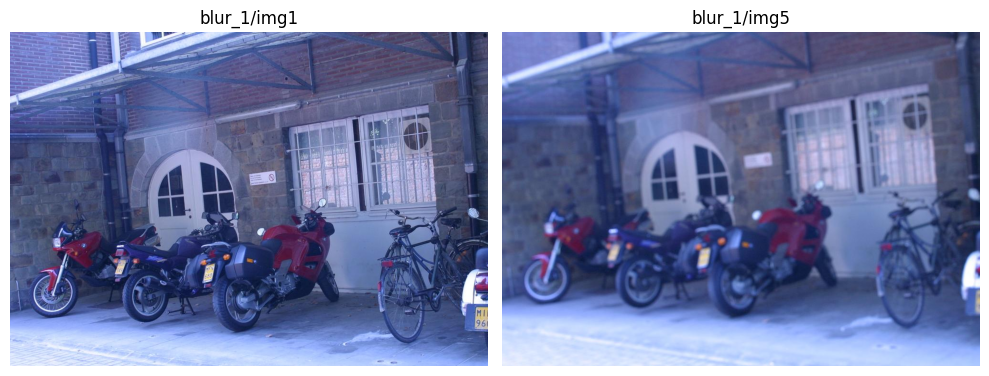

In [25]:
# pick your distortion folder and image indices:
folder = 'blur_1'
i1, i2 = 1, 5

# grab the BGR images
img1_bgr = data[folder]['images'][i1]
img2_bgr = data[folder]['images'][i2]

# convert to RGB for matplotlib
img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

# plot side by side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img1)
plt.title(f'{folder}/img{i1}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title(f'{folder}/img{i2}')
plt.axis('off')

plt.tight_layout()
plt.show()

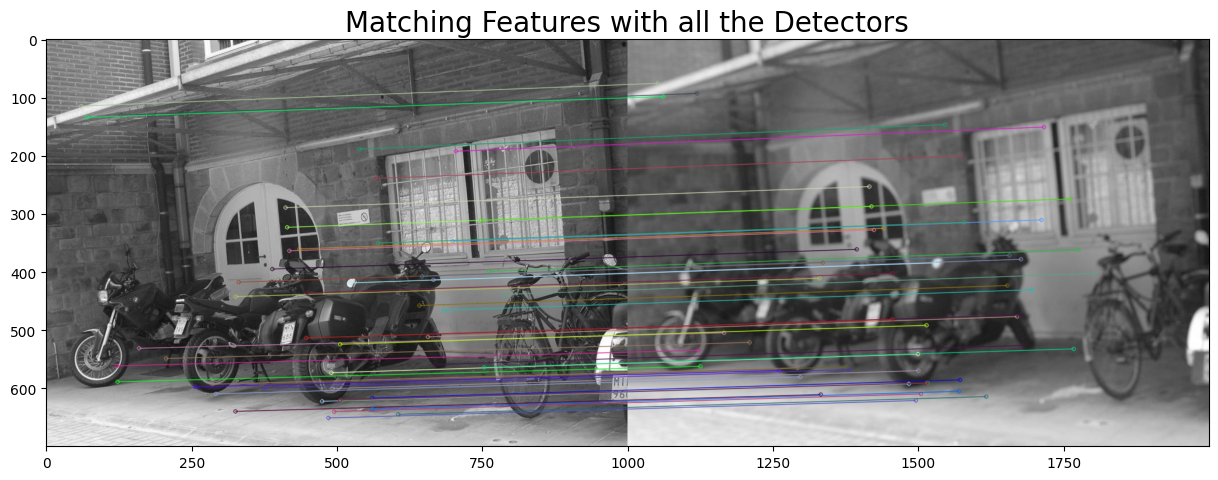

In [115]:
%matplotlib inline

img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)

# #surf
# surf = cv2.xfeatures2d.SURF_create()

# keypoints_1, descriptors_1 = surf.detectAndCompute(img1,None)
# keypoints_2, descriptors_2 = surf.detectAndCompute(img2,None)

# #feature matching
# bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

# matches = bf.match(descriptors_1,descriptors_2)
# matches = sorted(matches, key = lambda x:x.distance)

# plt.rcParams['figure.figsize'] = (15, 18)
# img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
# plt.imshow(img3)
# plt.title('Matching Features with all the Detectors', fontsize = 20)
# plt.show()

In [189]:
def evaluate_matching_performance(img1, img2, homography, descriptor_type, distance_threshold=100, pixel_error_threshold=3.0):
    """
    Evaluate descriptor matching with accurate recall calculation and runtime measurement.
    """
    # Start timing
    start_time = time.time()

    # First, find all possible correspondences (ground truth)
    correspondences, keypoints1, keypoints2, descriptors1, descriptors2 = find_correspondences_efficient(
        img1, img2, homography, descriptor_type, pixel_error_threshold
    )

    # Match descriptors
    bf = cv2.BFMatcher()
    matches = bf.match(descriptors1, descriptors2)

    # Apply distance threshold
    thresholded_matches = [m for m in matches if m.distance < distance_threshold]

    # Check which matches are correct based on our ground truth correspondences
    correct_matches = []
    false_matches = []
    correspondence_pairs = set(correspondences)
    for m in thresholded_matches:
        if (m.queryIdx, m.trainIdx) in correspondence_pairs:
            correct_matches.append(m)
        else:
            false_matches.append(m)

    # Calculate recall
    num_correct_matches = len(correct_matches)
    num_correspondences = len(correspondences)
    num_false_matches = len(false_matches)
    recall = num_correct_matches / max(1, num_correspondences)  # Avoid division by zero

    # Calculate 1-precision using the formula
    one_minus_precision = num_false_matches / max(1, num_correct_matches + num_false_matches)
    precision = 1 - one_minus_precision

    # Create visualization
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], img2, flags=2)

    # Calculate runtime
    runtime = time.time() - start_time

    # Prepare results
    results = {
        "descriptor_type": descriptor_type,
        "total_keypoints_img1": len(keypoints1),
        "total_keypoints_img2": len(keypoints2),
        "total_matches": len(matches),
        "thresholded_matches": len(thresholded_matches),
        "num_correspondences": num_correspondences,
        "num_correct_matches": num_correct_matches,
        "num_false_matches": num_false_matches,
        "recall": recall,
        "precision": precision,
        "1-precision": one_minus_precision
    }

    return results, img_matches, runtime

In [190]:
def find_correspondences_efficient(img1, img2, homography, descriptor_type, pixel_error_threshold=3.0):
    """
    Find all potential correspondences efficiently using spatial indexing.
    """
    # Extract features using the specified descriptor
    keypoints1, descriptors1,  = extract_features(img1, descriptor_type)
    keypoints2, descriptors2 = extract_features(img2, descriptor_type)

    # Convert keypoints to numpy arrays for faster processing
    kp1_array = np.array([kp.pt for kp in keypoints1])
    kp2_array = np.array([kp.pt for kp in keypoints2])

    # Build KD-Tree for keypoints in img2 for efficient nearest-neighbor search
    tree = cKDTree(kp2_array)

    correspondences = []
    h2, w2 = img2.shape[:2]

    try:
        # Apply homography to all points at once
        kp1_transformed = []
        for pt in kp1_array:
            pt_h = np.array([pt[0], pt[1], 1.0])
            pt_transformed = np.dot(homography, pt_h)
            # Convert from homogeneous coordinates
            pt_transformed = pt_transformed[:2] / pt_transformed[2]
            kp1_transformed.append(pt_transformed)

        kp1_transformed = np.array(kp1_transformed)

        # Find valid points (within image boundaries)
        valid_indices = np.where(
            (kp1_transformed[:, 0] >= 0) &
            (kp1_transformed[:, 0] < w2) &
            (kp1_transformed[:, 1] >= 0) &
            (kp1_transformed[:, 1] < h2)
        )[0]

        # Query the KD-Tree for nearest neighbors
        distances, indices = tree.query(kp1_transformed[valid_indices], k=1)

        # Filter by distance threshold
        valid_correspondences = np.where(distances < pixel_error_threshold)[0]

        # Create correspondence list
        for i, idx in enumerate(valid_correspondences):
            orig_idx = valid_indices[idx]
            nearest_idx = indices[idx]
            correspondences.append((orig_idx, nearest_idx))

    except Exception as e:
        print(f"Error in transformation: {e}")

    return correspondences, keypoints1, keypoints2, descriptors1, descriptors2

In [191]:
def extract_features(img, descriptor_type):
    """
    Extract features using Hessian detector and specified descriptor type.
    Returns keypoints and descriptors.
    """
    # Convert image to grayscale if needed
    if len(img.shape) > 2 and img.shape[2] > 1:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img.copy()

    # Use Hessian detector consistently
    hessian_detector = cv2.xfeatures2d.SURF_create(hessianThreshold=100, extended=False, upright=False)
    keypoints = hessian_detector.detect(gray_img, None)
    descriptors = None

    # Apply different descriptors based on type
    if descriptor_type == "sift":
        sift = cv2.SIFT_create()
        _, descriptors = sift.compute(gray_img, keypoints)
    elif descriptor_type == "surf":
        surf = cv2.xfeatures2d.SURF_create()
        _, descriptors = surf.compute(gray_img, keypoints)

    descriptors = np.float32(descriptors)
    return keypoints, descriptors

In [214]:
def display_matching_results(img_matches, results, descriptor_type=None):
    """
    Display the matching results visually and print evaluation metrics.

    Parameters:
    - img_matches: Image with matches drawn on it
    - results: Dictionary with matching statistics
    - descriptor_type: Optional descriptor type string (if not in results)
    """
    # Set figure size for better display
    plt.rcParams['figure.figsize'] = (15, 18)

    # Display the image with matches
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))

    # Create a more descriptive title
    plt.title(f'Feature Matching with {descriptor_type} Descriptor')

    # Print results to console as well
    print(f"\n--- Results for {descriptor_type} Descriptor ---")
    print(f"Keypoints: {results['total_keypoints_img1']} (img1), {results['total_keypoints_img2']} (img2)")
    print(f"Matches: {results['thresholded_matches']} (after threshold) / {results['total_matches']} (total)")
    print(f"Correct/False: {results['num_correct_matches']} / {results['num_false_matches']}")
    print(f"Recall: {results['recall']:.4f}, 1-Precision: {results['1-precision']:.4f}")

    # Turn off axis for cleaner look
    plt.axis('off')
    plt.show()
    return

In [215]:
# Import required libraries
homography = data['blur_1']['transforms'][(1, 5)]
descriptor_type = "sift"

# Run the evaluation
results, img_matches, exec_time = evaluate_matching_performance(
    img1, img2, homography, descriptor_type=descriptor_type,
    distance_threshold=100, pixel_error_threshold=3.0
)

Running Time: 4.496346950531006

--- Results for sift Descriptor ---
Keypoints: 5773 (img1), 2033 (img2)
Matches: 778 (after threshold) / 5773 (total)
Correct/False: 549 / 229
Recall: 0.2737, 1-Precision: 0.2943


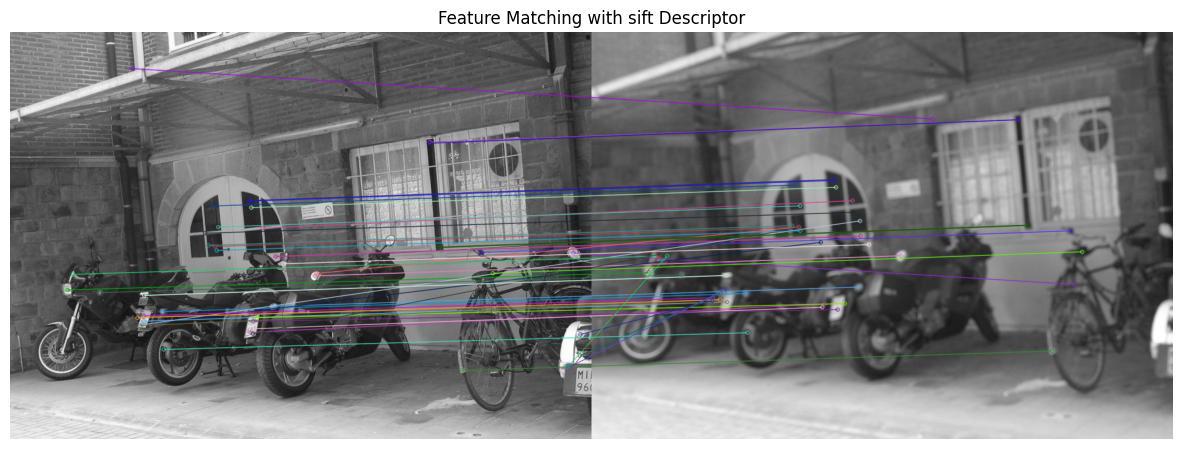

In [216]:
print(f"Running Time: {exec_time}")
display_matching_results(img_matches, results, descriptor_type)

In [217]:
descriptor_type = "surf"
results, img_matches, exec_time = evaluate_matching_performance(
    img1, img2, homography, descriptor_type=descriptor_type,
    distance_threshold=100, pixel_error_threshold=3.0
)

Running Time: 3.3752896785736084

--- Results for surf Descriptor ---
Keypoints: 5773 (img1), 2033 (img2)
Matches: 5773 (after threshold) / 5773 (total)
Correct/False: 982 / 4791
Recall: 0.4895, 1-Precision: 0.8299


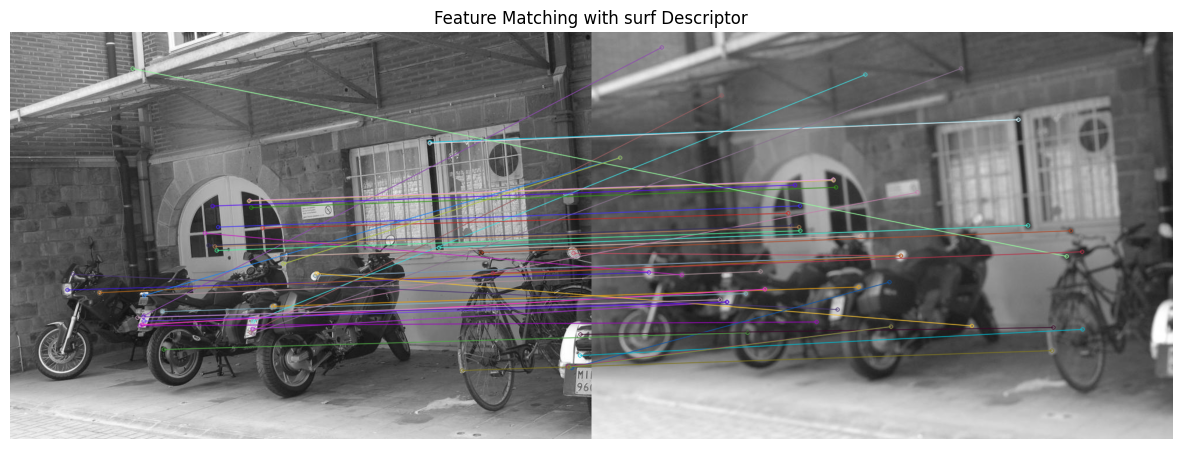

In [218]:
print(f"Running Time: {exec_time}")
display_matching_results(img_matches, results, descriptor_type)

In [221]:
def evaluate_all_image_pairs(data, descriptor_types=["sift", "surf", "orb"]):
    """
    Evaluate feature matching performance across all image pairs in the dataset.

    Parameters:
    - data: The loaded dataset with images and homography matrices
    - descriptor_types: List of descriptor types to evaluate

    Returns:
    - A dictionary with evaluation results for each image pair and descriptor
    """
    all_results = {}

    for folder_name, folder_data in data.items():
        if "2" in folder_name:
            continue

        print(f"\nProcessing folder: {folder_name}")
        all_results[folder_name] = {}

        # Get the images and transforms for this folder
        images = folder_data['images']
        transforms = folder_data['transforms']


        # Process each image pair with a known homography
        for (i, j), homography in transforms.items():
            # Only process if both images exist in the dataset
            if i in images and j in images:
                img1 = images[i]
                img2 = images[j]
                pair_key = f"img{i}_to_img{j}"

                print(f"Processing image pair: {pair_key}")
                all_results[folder_name][pair_key] = {}

                img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
                img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

                # Evaluate with each descriptor type
                for descriptor_type in descriptor_types:
                    print(f"Using {descriptor_type} descriptor...")

                    # Run the evaluation
                    results, img_matches, exec_time = evaluate_matching_performance(
                        img1, img2, homography,
                        descriptor_type=descriptor_type,
                        distance_threshold=100,
                        pixel_error_threshold=3.0
                    )

                    # Store results
                    all_results[folder_name][pair_key][descriptor_type] = {
                        'results': results,
                        'img_matches': img_matches,
                        'runtime': exec_time
                    }

                    # Display results
                    display_matching_results(img_matches, results, descriptor_type)
                    print()
            else:
                print(f"  Skipping pair ({i}, {j}) because one or both images are missing")

    return all_results

In [222]:
all_results = evaluate_all_image_pairs(data, ["sift","surf"])

Output hidden; open in https://colab.research.google.com to view.

In [240]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_folder_summaries(all_results):
    """
    Create visual performance summaries for each folder in the dataset,
    showing only charts without text tables, with three graphs in one row.
    Shows Recall, 1-Precision, and Runtime metrics.

    Parameters:
    - all_results: Dictionary containing all evaluation results
    """
    # Extract the data into a list of dictionaries for easier analysis
    data = []

    for folder_name, folder_results in all_results.items():
        for pair_key, pair_results in folder_results.items():
            for desc_type, desc_data in pair_results.items():
                result = desc_data['results']
                runtime = desc_data['runtime']

                data.append({
                    'Folder': folder_name,
                    'Image Pair': pair_key,
                    'Descriptor': desc_type,
                    'Recall': result['recall'],
                    'Precision': result['precision'],
                    '1-Precision': result['1-precision'],
                    'Correct Matches': result['num_correct_matches'],
                    'False Matches': result['num_false_matches'],
                    'Total Keypoints Img1': result['total_keypoints_img1'],
                    'Total Keypoints Img2': result['total_keypoints_img2'],
                    'Runtime (s)': runtime
                })

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Get unique folders
    folders = df['Folder'].unique()

    # Create separate summary plots for each folder
    for folder in folders:
        folder_df = df[df['Folder'] == folder]

        # Set up a 1x3 figure layout (three graphs in one row)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        plt.suptitle(f'Performance Summary for {folder}', fontsize=16)

        # 1. Bar chart of average recall by descriptor type
        avg_recall = folder_df.groupby('Descriptor')['Recall'].mean().reset_index()
        sns.barplot(x='Descriptor', y='Recall', data=avg_recall, ax=axes[0], palette='viridis')
        axes[0].set_title('Average Recall', fontsize=14)
        axes[0].set_ylim(0, 1)

        # Add value labels
        for i, bar in enumerate(axes[0].patches):
            axes[0].text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f'{bar.get_height():.3f}',
                ha='center', fontsize=10
            )

        # 2. Bar chart of average 1-Precision by descriptor type (using 1-Precision instead of Precision)
        avg_one_minus_precision = folder_df.groupby('Descriptor')['1-Precision'].mean().reset_index()
        sns.barplot(x='Descriptor', y='1-Precision', data=avg_one_minus_precision, ax=axes[1], palette='viridis')
        axes[1].set_title('Average 1-Precision', fontsize=14)
        axes[1].set_ylim(0, 1)

        # Add value labels
        for i, bar in enumerate(axes[1].patches):
            axes[1].text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f'{bar.get_height():.3f}',
                ha='center', fontsize=10
            )

        # 3. Bar chart of average runtime by descriptor type
        avg_runtime = folder_df.groupby('Descriptor')['Runtime (s)'].mean().reset_index()
        sns.barplot(x='Descriptor', y='Runtime (s)', data=avg_runtime, ax=axes[2], palette='viridis')
        axes[2].set_title('Average Runtime (seconds)', fontsize=14)

        # Add value labels
        for i, bar in enumerate(axes[2].patches):
            axes[2].text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f'{bar.get_height():.3f}',
                ha='center', fontsize=10
            )

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # Adjust for title
        plt.show()

    return df  # Return the DataFrame for any additional analysis

<ipython-input-240-f95960b7931a>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Recall', data=avg_recall, ax=axes[0], palette='viridis')
<ipython-input-240-f95960b7931a>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='1-Precision', data=avg_one_minus_precision, ax=axes[1], palette='viridis')
<ipython-input-240-f95960b7931a>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Runtime (s)', data=avg_runtime, ax=axes[2], palette='viridis')


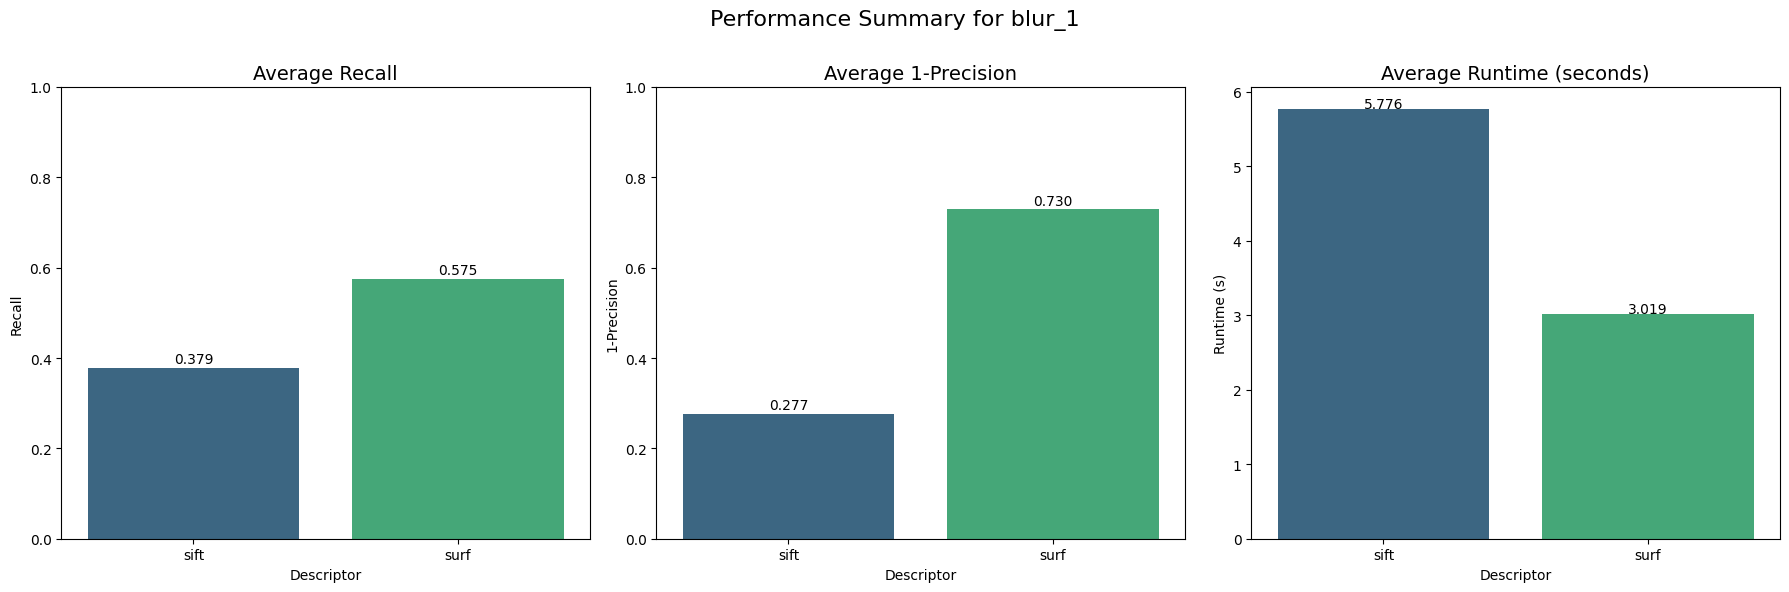

<ipython-input-240-f95960b7931a>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Recall', data=avg_recall, ax=axes[0], palette='viridis')
<ipython-input-240-f95960b7931a>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='1-Precision', data=avg_one_minus_precision, ax=axes[1], palette='viridis')
<ipython-input-240-f95960b7931a>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Runtime (s)', data=avg_runtime, ax=axes[2], palette='viridis')


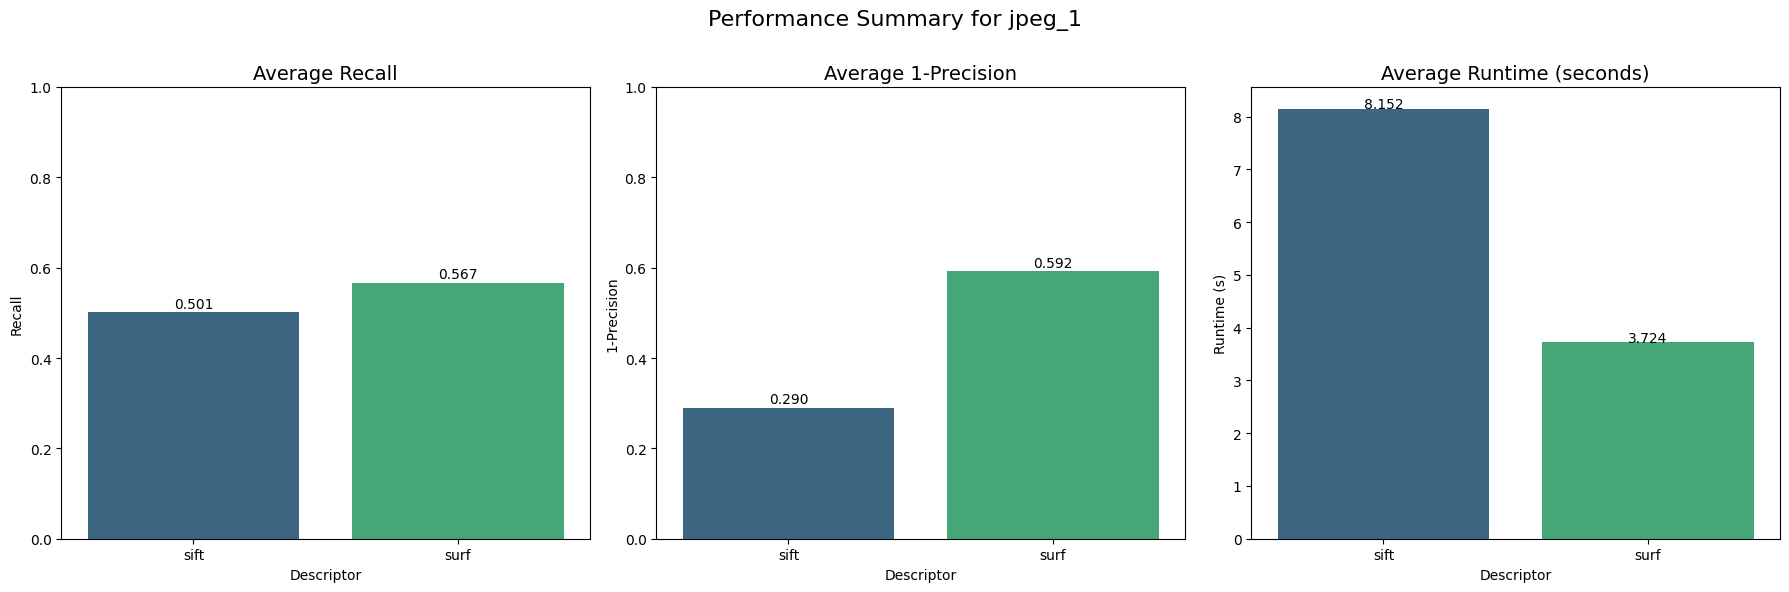

<ipython-input-240-f95960b7931a>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Recall', data=avg_recall, ax=axes[0], palette='viridis')
<ipython-input-240-f95960b7931a>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='1-Precision', data=avg_one_minus_precision, ax=axes[1], palette='viridis')
<ipython-input-240-f95960b7931a>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Runtime (s)', data=avg_runtime, ax=axes[2], palette='viridis')


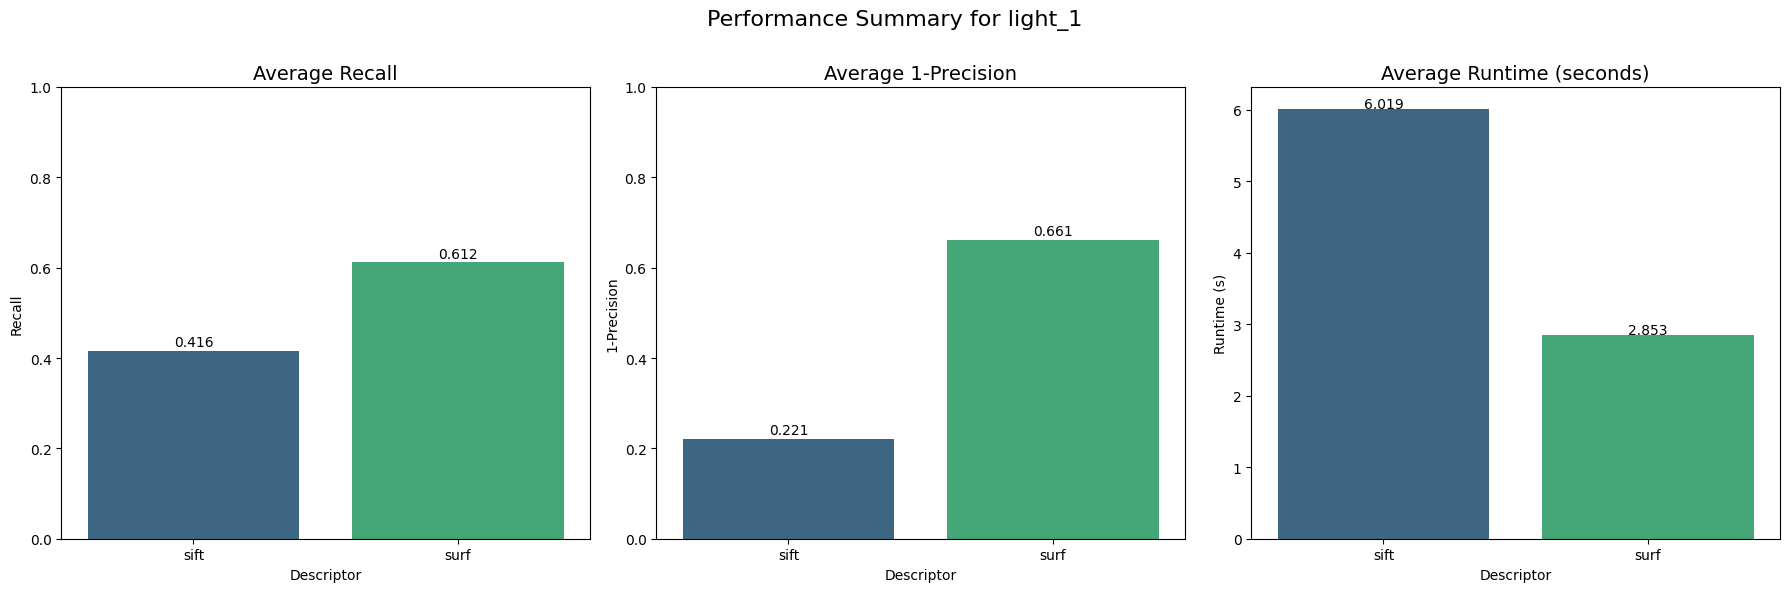

<ipython-input-240-f95960b7931a>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Recall', data=avg_recall, ax=axes[0], palette='viridis')
<ipython-input-240-f95960b7931a>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='1-Precision', data=avg_one_minus_precision, ax=axes[1], palette='viridis')
<ipython-input-240-f95960b7931a>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Runtime (s)', data=avg_runtime, ax=axes[2], palette='viridis')


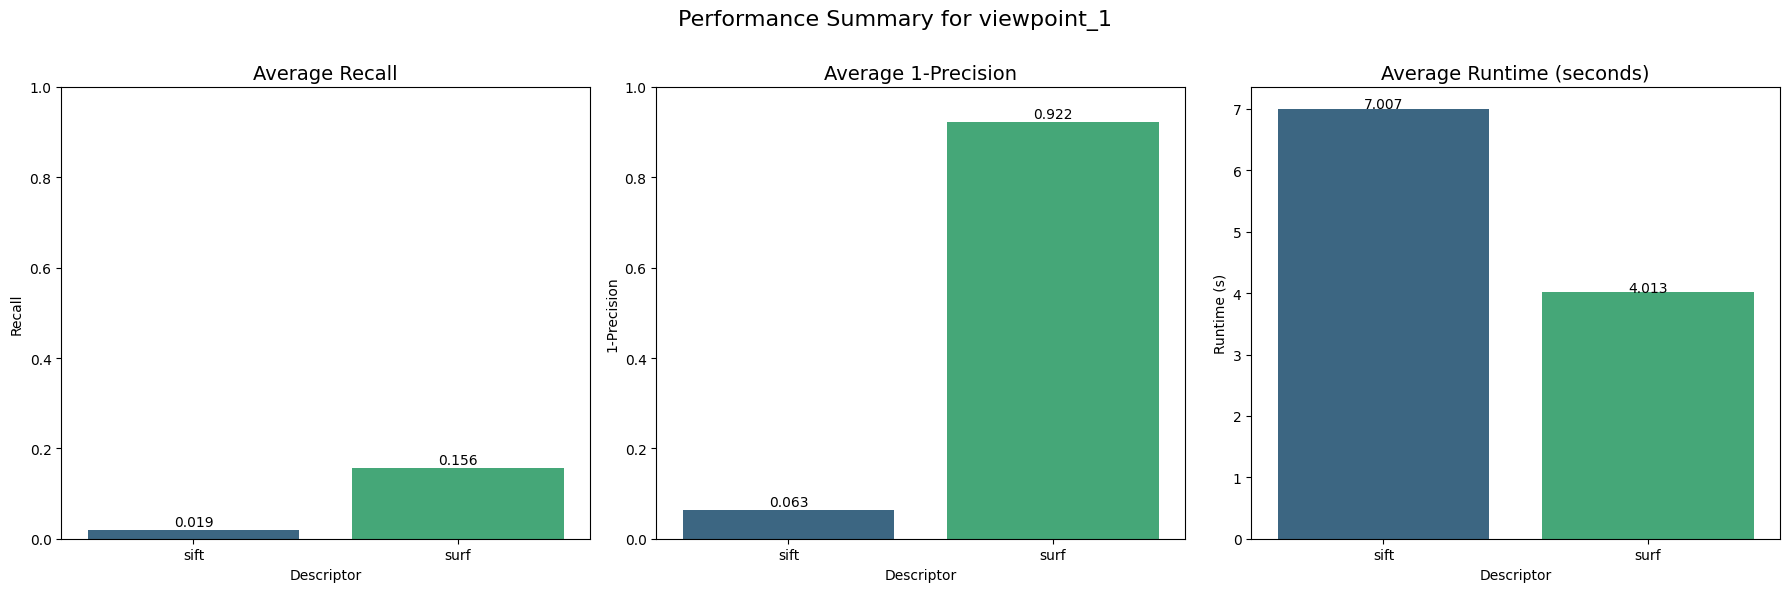

<ipython-input-240-f95960b7931a>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Recall', data=avg_recall, ax=axes[0], palette='viridis')
<ipython-input-240-f95960b7931a>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='1-Precision', data=avg_one_minus_precision, ax=axes[1], palette='viridis')
<ipython-input-240-f95960b7931a>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Descriptor', y='Runtime (s)', data=avg_runtime, ax=axes[2], palette='viridis')


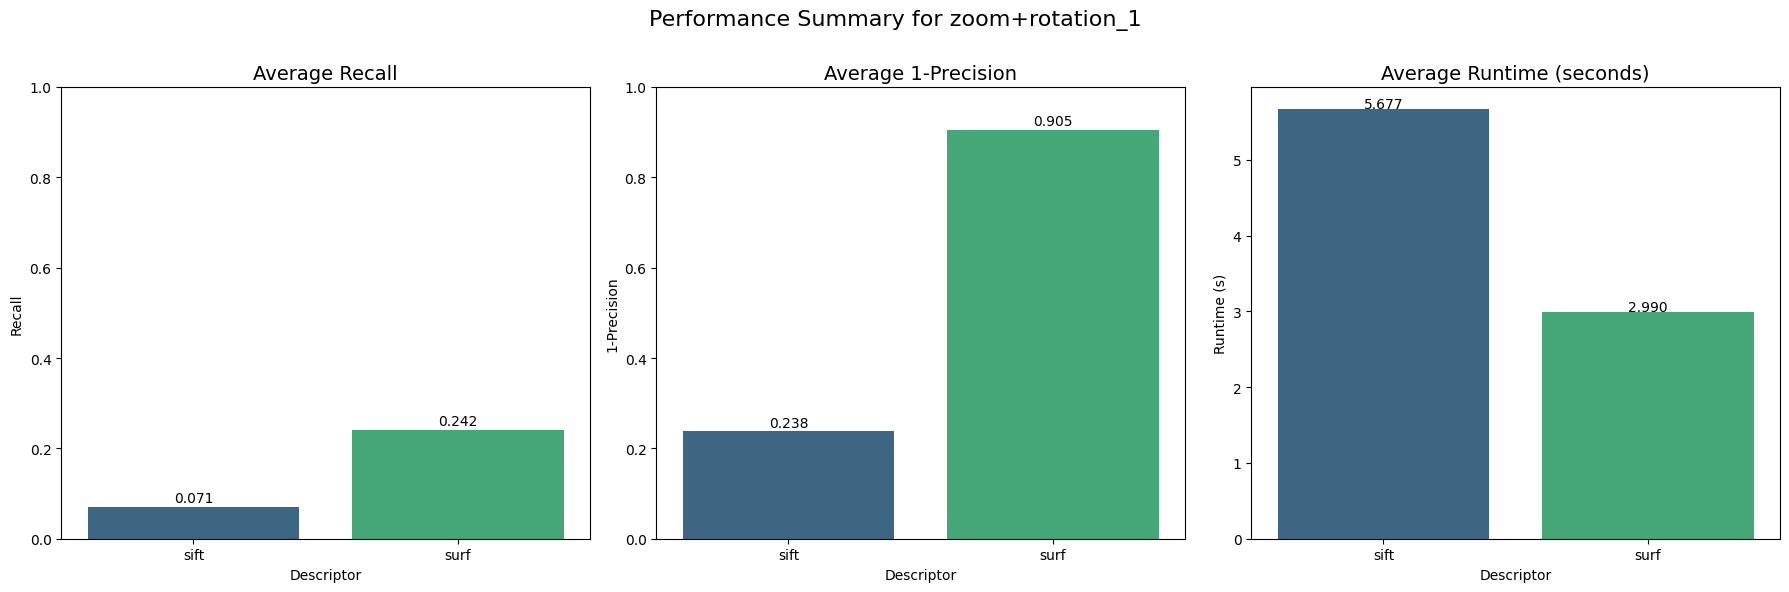

In [241]:
df = plot_folder_summaries(all_results)